In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as sps
from matplotlib import pyplot as plt
from math import factorial as fact

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 12, 7
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 16

SEED = 42
np.random.seed(seed=SEED)

## Задача 1

**Класс для семплирования X, w, y из совместного распределения**

In [4]:
class JointDistribution(sps.rv_continuous):
    def __init__(self, alpha, sigma, n, 
                 x_seed=None, w_seed=None, y_seed=None):
        super().__init__(self)
        
        self.x_distr = sps.multivariate_normal(
            mean=np.zeros(n),
            cov=np.eye(n)*sigma,
            seed=x_seed
        )
        self.w_distr = sps.multivariate_normal(
            mean=np.zeros(n),
            cov=np.eye(n)/alpha,
            seed=w_seed
        )
        self.unif_distr = sps.uniform()
        self.unif_seed = y_seed
        self.n = n
    
    def _calc_y_proba(self, objects, weights):
        assert objects.ndim <= 2 and weights.ndim == 1
        
        if objects.ndim == 1:
            objects = objects.reshape(1, -1)
        
        return 1 / (1 + np.exp(-np.einsum("ij, j -> i", objects, weights)))
        
    def rvs(self, size):
        if not isinstance(size, int):
            raise ValueError(f"Expect type(size) == int, got {type(size)}")
        
        # objects.shape = (size, self.n)
        # weights.shape = (self.n)
        objects = self.x_distr.rvs(size)
        weights = self.w_distr.rvs(1)
        
        y_probas = self._calc_y_proba(objects, weights)
        bool_targets = self.unif_distr.rvs(size, self.unif_seed) >= 1 - y_probas
        targets = 2 * bool_targets - 1
        
        return objects, weights, targets
    
    def _pdf(self, obj, weight, trg):
        x_proba = self.x_distr.pdf(obj)
        w_proba = self.w_distr.pdf(weight)
        
        y_proba = self._calc_y_proba(obj, weight)
        y_proba = np.where(trg == 1, y_probas, 1 - y_probas)
        
        return x_proba * w_proba * y_proba

**Функция для подсчёта логарифма апостериорной вер-ти весов и разных метрик**

In [53]:
def log_sigmoid(x: np.ndarray) -> np.ndarray:
    return -np.logaddexp(np.zeros_like(x), -x)

def sigmoid(x: np.ndarray) -> np.ndarray:
    return np.exp(log_sigmoid(x))

def posterior_prob(X_tr: np.ndarray, y_tr: np.ndarray, w: np.ndarray) -> float:
    """
    X_tr = numpy array of shape (m1, n)
    y_tr = numpy array of shape (m1,)
    w = numpy array of shape (n,)
    
    return -0.5 w.T @ w + \sum\limits_{i=1}^m1 \log \sigma (-y_tr^i w.T X_tr^i)
    """
    prior_part = -0.5 * np.linalg.norm(w)**2
    likelihood_part = np.sum(log_sigmoid(-X_tr @ w * y_tr))
    
    return prior_part + likelihood_part

def classifier_confidence(proba: np.ndarray) -> float:
    return np.sum(np.abs(proba - 0.5))

def test_sample_ll(proba: np.ndarray, y_test):
    proba = np.where(y_test, proba, 1 - proba)
    return np.sum(np.log(proba))

def argmax(func, x: np.ndarray) -> float:
    func_to_min = lambda x: -func(x)
    result = scipy.optimize.minimize(func_to_min, x, bounds=[(-3, 3)]*x.size)
    
    return result.x

**Задаём константы**

In [54]:
n = 15
sigma = 1**2
alpha = 1**2
train_size = 1000
test_size = 1000
x_seed = SEED
w_seed = SEED+1
y_seed = SEED+2

distr = JointDistribution(alpha, sigma, n, x_seed, w_seed, y_seed)
x, w_true, y = distr.rvs(train_size+test_size)
x_train, x_test = x[:train_size, :], x[train_size:, :]
y_train, y_test = y[:train_size], y[train_size:]

**Пример для точечного MAP-классификатора с m1 = 1000**

In [55]:
w0 = np.zeros(n)

w_map = argmax(lambda w: posterior_prob(x_train, y_train, w), w0)
proba = sigmoid(-x_test @ w_map)
print("Confidence =", classifier_confidence(proba))
print("Log likelihood =", test_sample_ll(proba, y_test))

Confidence = 339.39814194016867
Log likelihood = -1450.935781683451


**Значение метрик для истинного веса**

In [56]:
proba_true = sigmoid(-x_test @ w_true)
print("Confidence =", classifier_confidence(proba_true))
print("Log likelihood =", test_sample_ll(proba_true, y_test))

Confidence = 349.1036779969106
Log likelihood = -1515.0112615718485


**Соответствие между y_true и proba**

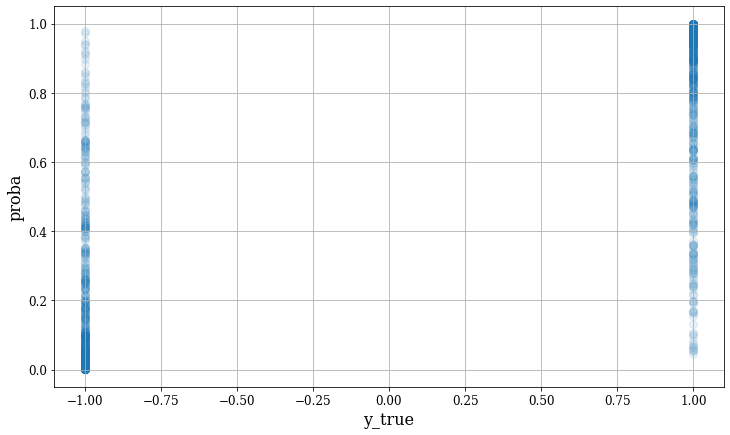

In [29]:
plt.scatter(y_test, proba, alpha=0.1)
plt.xlabel("y_true")
plt.ylabel("proba")
plt.grid(True)
plt.show()

**Точечный MAP-классификатор с разными размерами обучающей выборки**

In [57]:
train_sizes = (15, 50, 100, 500, 1000, 5000)
confs = []
log_likelihoods = []
K_OPTIM_REPEATS = 25

for train_size in train_sizes:
    x, w_true, y = distr.rvs(train_size+test_size)
    x_train, x_test = x[:train_size, :], x[train_size:, :]
    y_train, y_test = y[:train_size], y[train_size:]
    
    total_conf = 0
    total_log_llh = 0
    for _ in range(K_OPTIM_REPEATS):
        w0 = np.zeros(n)
        w_map = argmax(lambda w: posterior_prob(x_train, y_train, w), w0)
        proba = sigmoid(-x_test @ w_map)
        total_conf += classifier_confidence(proba)
        total_log_llh += test_sample_ll(proba, y_test)
    
    total_conf /= K_OPTIM_REPEATS
    total_log_llh /= K_OPTIM_REPEATS
    
    confs.append(total_conf)
    log_likelihoods.append(total_log_llh)

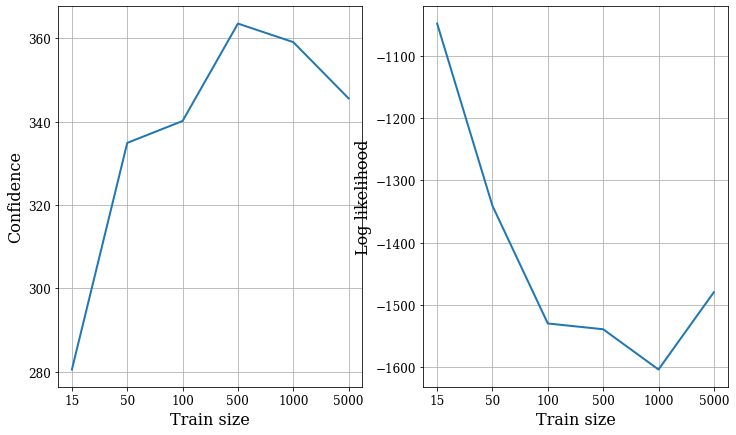

In [58]:
plt.subplot(121)
plt.plot(confs)
plt.xticks(ticks=range(len(train_sizes)), labels=[str(x) for x in train_sizes])
plt.xlabel("Train size")
plt.ylabel("Confidence")
plt.grid(True)

plt.subplot(122)
plt.plot(log_likelihoods)
plt.xticks(ticks=range(len(train_sizes)), labels=[str(x) for x in train_sizes])
plt.xlabel("Train size")
plt.ylabel("Log likelihood")
plt.grid(True)

**Вывод:** C ростом обучающей выборки качество предсказания ухудшается